<a href="https://colab.research.google.com/github/ailsonramon/Mathematical_Modeling/blob/main/TS_daily_analysis_energy_2000_2021_Brazillian_Northeast_Region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução a séries temporais

Uma série temporal é definida como um conjunto de valores que se modificam em intervalos iguais de tempo. 

Exemplo
* Valor de ativos na bolsa de valores
* População de um pais
* Quantidades de passageiros 

Os modelos utilizados para descrever séries temporais são **processos estocásticos**, isto é, processos controlados por leis probabilísticas. 

#Importação das libs

In [25]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
# melhorar a visualização
pd.set_option('max_columns',170)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Dataset

Neste exemplo iremos utilizar os dados de energia da ons.org relacionado aos dados de demanda instantanea, no período de 2000-2021, na região Nordeste do Brazil.
disponível: http://www.ons.org.br/paginas/resultados-da-operacao/historico-da-operacao

In [39]:
col_list = ["Data Escala de Tempo 1 DM Simp 4","Selecione Tipo de DM Simp 4"]
#Import Dataframe and parse date columns for datetime64[ns]
df = pd.read_csv('/content/drive/Shareddrives/Modelagem_Analitica/Ailson/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv'
     ,usecols=col_list, parse_dates=["Data Escala de Tempo 1 DM Simp 4"])

#Rename the columns
df.rename(columns = {'Data Escala de Tempo 1 DM Simp 4':'days','Selecione Tipo de DM Simp 4':'energia'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7701 entries, 0 to 7700
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   days     7701 non-null   datetime64[ns]
 1   energia  7701 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 120.5 KB


Em seguida, transformaremos a coluna 'days' como a coluna indexadora dos demais utilizando o comando ```DataFrame.set_indes()```



In [42]:
df.set_index('days', inplace=True)

Podemos perceber que a coluna 'days' desaparece, porque ela deixa de ser uma coluna e passa a se comportar como um índice

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7701 entries, 2000-01-01 00:00:00 to 2021-01-31 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   energia  7701 non-null   float64
dtypes: float64(1)
memory usage: 120.3 KB


Essa transformação inicial é necessária para a plotagem do gráfica da série temporal. Onde por definição ele utiliza o eixo X o índice que indicamos na tabela. 

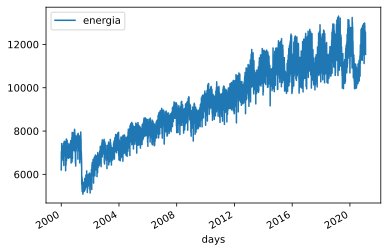

In [46]:
df.plot()

Validação dos dados formatados

#Análise exploratória dos dados

Análise do gráfico

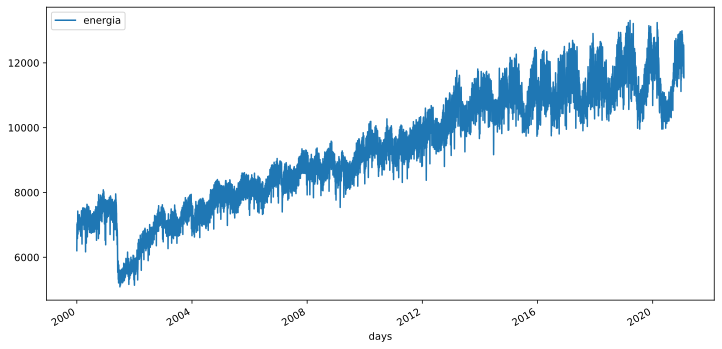

In [52]:
df.plot(figsize=(12,6))

Total data:3850


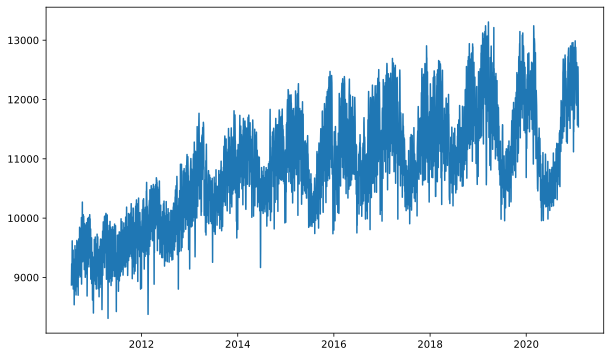

In [15]:
#Select a percentage from the time series
data_proportion = lambda serie, percent=1.0: serie[-int(percent * len(serie)):]
ts_50_per = data_proportion(ts_format, percent=0.50)
print(f'Total data:{len(ts_50_per)}')
plt.rcParams["figure.figsize"] = [10,6]
plt.plot(ts_50_per)

In [16]:
type(ts_50_per)

pandas.core.series.Series

#Análise semanal

Total of Date:154


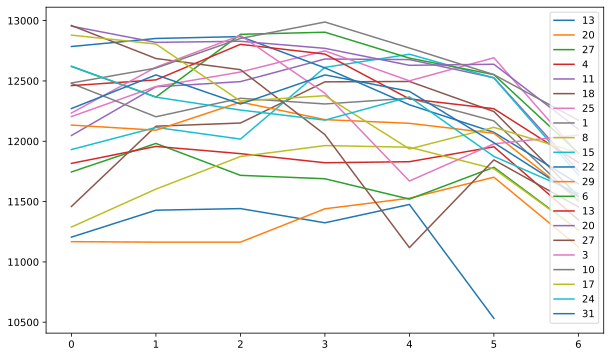

In [17]:
def weekly_plot(serie):
  groups = serie[8:].groupby(pd.Grouper(freq='W'))
  values = list()
  days = list()
  for name, group in groups:
    df = pd.DataFrame(group.values)
    values.append(df)
    days.append(name.day)
  df = pd.concat(values, ignore_index=True, axis=1)
  df.columns = days
  df.plot(subplots=False, legend=True)
  
ts_02_percent = data_proportion(ts_format, percent=0.02)
print(f'Total of Date:{len(ts_02_percent)}')
weekly_plot(ts_02_percent)

#Análise Mensal

Total of Date:616


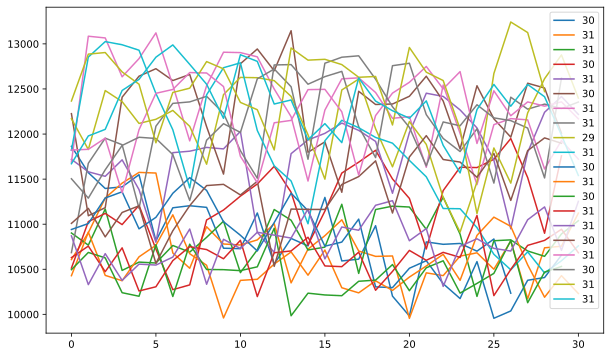

In [18]:
def month_plot(serie):
  groups = serie[8:].groupby(pd.Grouper(freq='M'))
  values = list()
  days = list()
  for name, group in groups:
    df = pd.DataFrame(group.values)
    values.append(df)
    days.append(name.day)
  df = pd.concat(values, ignore_index=True, axis=1)
  df.columns = days
  df.plot(subplots=False, legend=True)

ts_08_percent = data_proportion(ts_format, percent=0.08)
print(f'Total of Date:{len(ts_08_percent)}')
month_plot(ts_08_percent)

#Distribuição de Frequência
Para 50% do dataset

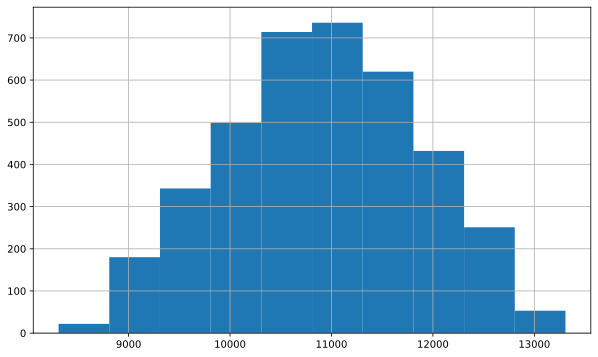

In [19]:
ts_50_per.hist()
plt.rcParams["figure.figsize"] = [1,1]
plt.show()

O Histograma apresenta uma distribuição gaussiana, indicando que a série é estacionária.

#Característica estatísticas

In [20]:
X = ts_50_per
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()

var1, var2 = X1.var(), X2.var()
print("Media da primeira parte: %f, \nMedia da segunda parte:%f" %(mean1, mean2))
#print(f"variancia1:{var1} \nvariancia2:{var2}")
print("Variancia1:%f\nVariancia2:%f" % (var1,var2))

Media da primeira parte: 10331.358625, 
Media da segunda parte:11496.474248
Variancia1:614193.696174
Variancia2:527129.149157


Tanto a média quanto a variância contém pouca variação entre as metades das amostras. 
Isso também indica que a série é estacionária

In [21]:
def plot_mean_var_ts(timeseries):
  #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=240).mean()
    rolstd = pd.Series(timeseries).rolling(window=240).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [22]:
def test_dickfuller(timeseries):
  #Reference:https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
  result = adfuller(x=timeseries,autolag='AIC')
  dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  print('ADF   statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)


In [23]:
def test_kpss(timeseries):
  print('\nResults of KPSS Test:')
  result = kpss(timeseries, regression='c')
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[3].items():
      print('Critial Values:')
      print(f'   {key}, {value}')

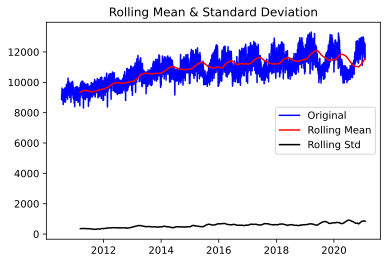

ADF   statistic: -2.935432
p-value: 0.041380
Critical Values:
Test Statistic                   -2.935432
p-value                           0.041380
#Lags Used                       30.000000
Number of Observations Used    3819.000000
Critical Value (1%)              -3.432063
Critical Value (5%)              -2.862297
Critical Value (10%)             -2.567173
dtype: float64

Results of KPSS Test:


NameError: ignored

In [49]:
def check_stationary(timeseries):
  plot_mean_var_ts(timeseries)
  test_dickfuller(timeseries)
  test_kpss(timeseries)

check_stationary(ts_50_per)

In [ ]:
ts_log = np.log(ts_10_percent)
plt.plot(ts_log)
test_stationarity(ts_log)

In [ ]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [ ]:
import seaborn as sns
import statsmodels.api as sm
#Decompose a time serie
decomposition = sm.tsa.seasonal_decompose(ts_10_percent, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()